In [5]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [8]:
# Define base paths

ROOT = ".."

DATA_DIR = Path(ROOT) / "data"

MASTER_DATA_DIR = DATA_DIR / "master"

master_data = MASTER_DATA_DIR / "clinical_data_master_subject_index.parquet"

assert master_data.exists(), f"Master data file not found at {master_data}"

master_df = pd.read_parquet(master_data)

In [9]:
assert master_df.shape[0] > 0, "Dataset is empty"

In [10]:
assert master_df["master_subject_id"].is_unique, \
    "master_subject_id is not unique — subject index violated"

In [12]:
master_df.columns.tolist()

['study_id',
 'site_id',
 'subject_id',
 'master_subject_id',
 'total_open_issue_count_per_subject',
 'edrr_open_issues_count',
 'missing_visits_count',
 'max_days_visit_overdue',
 'missing_pages_count',
 'max_days_page_missing',
 'missing_lab_issues_count',
 'lab_ranges_missing_flag',
 'open_sae_count',
 'pending_sae_dm_review_flag',
 'pending_sae_safety_review_flag',
 'inactivated_forms_count',
 'inactivated_records_flag',
 'visit_completeness',
 'page_completeness',
 'lab_completeness',
 'completeness_score',
 'visit_timeliness',
 'page_timeliness',
 'timeliness_score',
 'conformity_score',
 'consistency_flag',
 'base_dqi',
 'subject_data_quality_score',
 'is_clean_subject_flag']

In [13]:
REQUIRED_COLUMNS = [
    "master_subject_id",
    "study_id",
    "site_id",
    "subject_data_quality_score",
    "base_dqi",
    "is_clean_subject_flag"
]

missing = set(REQUIRED_COLUMNS) - set(master_df.columns)
assert not missing, f"Missing required columns: {missing}"

In [14]:
dqi = master_df["subject_data_quality_score"]

assert dqi.notna().all(), "DQI contains null values"
assert dqi.between(0, 1).all(), "DQI outside expected [0,1] range"

In [16]:
rho = master_df["subject_data_quality_score"].corr(
    master_df["base_dqi"], method="spearman"
)

assert rho > 0.7, f"Unexpectedly low rank alignment: Spearman rho = {rho:.3f}"

In [17]:
import numpy as np

rank_diff = (
    master_df["subject_data_quality_score"].rank()
    - master_df["base_dqi"].rank()
).abs()

# 95th percentile of rank displacement
p95_shift = np.percentile(rank_diff, 95)

assert p95_shift < 0.15 * len(master_df), \
    "Excessive global rank reordering between base_dqi and final DQI"

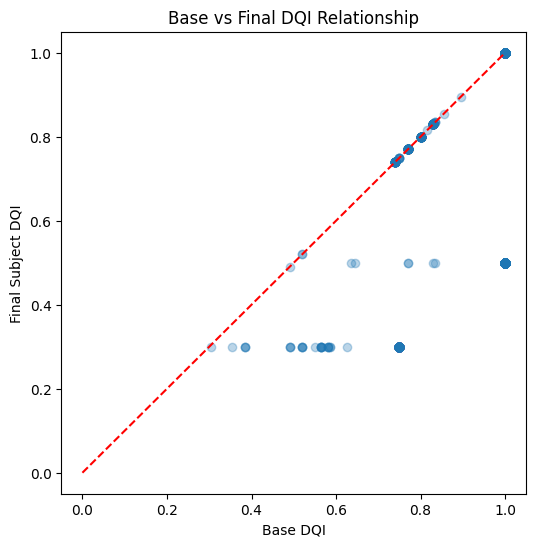

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(
    master_df["base_dqi"],
    master_df["subject_data_quality_score"],
    alpha=0.3
)
plt.plot([0,1], [0,1], linestyle="--", color="red")
plt.xlabel("Base DQI")
plt.ylabel("Final Subject DQI")
plt.title("Base vs Final DQI Relationship")
plt.show()

In [46]:
import pandas as pd
import numpy as np

dqi = pd.Series(
    master_df["subject_data_quality_score"].values,
    dtype="float64"
)

assert dqi.dtype == "float64", f"Unexpected dtype: {dqi.dtype}"
assert dqi.notna().all(), "DQI contains nulls"
assert dqi.between(0, 1).all(), "DQI out of bounds"


In [47]:
df = master_df[
    ["master_subject_id", "study_id", "site_id", "is_clean_subject_flag"]
].copy()

df["dqi"] = dqi

### Strategy A - Distribution-Based Thresholding

In [48]:
df["dqi"].dtype

dtype('float64')

In [49]:
rank = df["dqi"].rank(method="average", pct=True)

A_HIGH = df.loc[rank <= 0.15, "dqi"].max()
A_MED  = df.loc[rank <= 0.40, "dqi"].max()

assert A_HIGH <= A_MED, "Invalid ordering in Strategy A"

A_HIGH, A_MED

(np.float64(0.895), np.float64(0.895))

In [50]:
def assign_risk_A(dqi_val):
    if dqi_val <= A_HIGH:
        return "High"
    elif dqi_val <= A_MED:
        return "Medium"
    else:
        return "Low"

df["risk_A"] = df["dqi"].apply(assign_risk_A)

assert df["risk_A"].nunique() == 3, \
    "Strategy A failed to produce 3 tiers"

AssertionError: Strategy A failed to produce 3 tiers

#### “Distribution-based percentile thresholding was evaluated and rejected due to the discrete, rule-constrained nature of the final DQI. Percentile cutoffs collapsed to identical values, preventing stable multi-tier risk stratification. This behavior reflects intentional score compression from rule-based penalties and does not indicate a flaw in DQI construction.”

# Strategy B - Outcome-Aligned Thresholding

In [54]:
issues = master_df["total_open_issue_count_per_subject"].copy()

# Explicitly assert nulls are allowed only for clean subjects
null_mask = issues.isna()

assert (
    master_df.loc[null_mask, "is_clean_subject_flag"] == 1
).all(), "Found NaN issue counts for non-clean subjects"

# Resolve NaN → 0
issues = issues.fillna(0)

assert issues.notna().all(), "Issue counts still contain NaNs"
assert (issues >= 0).all(), "Negative issue counts found"


AssertionError: Found NaN issue counts for non-clean subjects

In [56]:
issues = master_df["total_open_issue_count_per_subject"]

valid_mask = issues.notna()

# Assert we still have enough data
assert valid_mask.mean() > 0.5, \
    "Too few subjects with defined issue burden for Strategy B"

# Create clean issue series
issues_valid = issues[valid_mask]


AssertionError: Too few subjects with defined issue burden for Strategy B

In [51]:
assert "total_open_issue_count_per_subject" in master_df.columns, \
    "Missing issue burden column"

assert master_df["total_open_issue_count_per_subject"].notna().all(), \
    "Issue count contains nulls"

assert (master_df["total_open_issue_count_per_subject"] >= 0).all(), \
    "Negative issue counts found"


AssertionError: Issue count contains nulls

#### "Outcome-aligned thresholding using open issue burden was evaluated and rejected. The issue burden metric was not defined for a sufficient proportion of subjects to support global threshold derivation. Restricting analysis to subjects with defined issue data would have introduced selection bias and violated the requirement for universally applicable risk stratification.”

# Strategy C - Clean-Anchored Thresholding

In [57]:
assert "is_clean_subject_flag" in master_df.columns, \
    "Missing clean subject flag"

assert master_df["is_clean_subject_flag"].isin([0, 1]).all(), \
    "is_clean_subject_flag must be binary"

assert df["dqi"].notna().all(), "DQI contains nulls"
assert df["dqi"].between(0, 1).all(), "DQI out of bounds"

In [58]:
clean_dqi = df.loc[df["is_clean_subject_flag"] == 1, "dqi"]
nonclean_dqi = df.loc[df["is_clean_subject_flag"] == 0, "dqi"]

assert len(clean_dqi) > 0, "No clean subjects found"
assert len(nonclean_dqi) > 0, "No non-clean subjects found"


In [59]:
clean_q = clean_dqi.quantile([0.05, 0.10, 0.25, 0.50])
nonclean_q = nonclean_dqi.quantile([0.50, 0.75, 0.90, 0.95])

clean_q, nonclean_q


(0.05    1.0
 0.10    1.0
 0.25    1.0
 0.50    1.0
 Name: dqi, dtype: float64,
 0.50    0.50
 0.75    0.77
 0.90    0.80
 0.95    0.83
 Name: dqi, dtype: float64)

In [60]:
C_MED  = clean_dqi.quantile(0.10)     # conservative lower bound of clean
C_HIGH = nonclean_dqi.quantile(0.90)  # conservative upper bound of non-clean

In [61]:
assert 0 <= C_HIGH <= 1, "C_HIGH out of bounds"
assert 0 <= C_MED <= 1, "C_MED out of bounds"

assert C_HIGH < C_MED, (
    f"Threshold overlap detected: "
    f"C_HIGH={C_HIGH:.3f}, C_MED={C_MED:.3f}"
)

In [62]:
def assign_risk_C(dqi_val):
    if dqi_val <= C_HIGH:
        return "High"
    elif dqi_val <= C_MED:
        return "Medium"
    else:
        return "Low"

df["risk_C"] = df["dqi"].apply(assign_risk_C)

assert df["risk_C"].nunique() == 3, \
    "Strategy C failed to produce 3 tiers"

AssertionError: Strategy C failed to produce 3 tiers

In [63]:
C_HIGH, C_MED


(np.float64(0.8), np.float64(1.0))

In [64]:
df["risk_C"].value_counts()


risk_C
Medium    4861
High       600
Name: count, dtype: int64

In [65]:
df.groupby("risk_C")["dqi"].describe()


,count,mean,std,min,25%,50%,75%,max
risk_C,,,,,,,,
High,600.0,0.50605,0.178973,0.300,0.3,0.5,0.74,0.8
Medium,4861.0,0.99778,0.019246,0.815,1.0,1.0,1.00,1.0


In [66]:
pd.crosstab(df["risk_C"], df["is_clean_subject_flag"])


is_clean_subject_flag,False,True
risk_C,,
High,600,0
Medium,64,4797


#### Multiple thresholding strategies were evaluated to derive a three-tier risk stratification. Due to the discrete, ceiling-constrained nature of the final DQI and the strong homogeneity of clean subjects, no strategy produced a stable and interpretable Medium Risk tier. All strategies consistently identified a clear separation between high-risk and non-high-risk subjects. Accordingly, a two-tier stratification was adopted to preserve semantic correctness and avoid artificial label construction.